# The Battle of Neighborhoods (Week 2)

## 1. Geographical coordinates dataset of New York city (Download and Explore)

This Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains 5 boroughs and neighborhoods that exist in each borough as well as the latitude and logitude coordinates of each neighborhood.

This dataset exists on the web and is readily available for use and it's link is: https://geo.nyu.edu/catalog/nyu_2451_34572

First, let's download all the dependencies that we will need for the coding.

In [288]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geocoder==1.5.0 # uncomment this line if you haven't completed the Foursquare API lab
import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!pip install folium==0.5.0 # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import csv # implements classes to read and write tabular data in CSV form

print('Libraries imported.')

Libraries imported.


In [289]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')

Data downloaded!


### Load and Explore Data

In [290]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

All the relevant data is in the features key, which is basically a list of the neighborhoods. So, define a new variable that includes this data.

In [291]:
neighborhoods_data = newyork_data['features']

Take a look at the first item in this list

In [292]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

### Transform data into Pandas dataframe

The next task is essentially transforming this data of nested Python dictionaries into a pandas dataframe. Let's start by creating an empty dataframe.

In [293]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [294]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then loop through the data and fill the dataframe one row at a time.

In [295]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [296]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Let's make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [297]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [298]:
neighborhoods.to_csv('BON1_NYC_GEO.csv',index=False)

Using geopy library to get the latitude and longitude values of New York City

In [299]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="Jupyter")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


Creating a map of New York city with neighborhoods superimposed on top

Folium is a great visualization library. We can zoom into the below map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

In [300]:
# create map of New York using latitude and longitude values
map_NewYork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NewYork)  
    
map_NewYork

## 2. Web scrapping of Population and Demographics data of New York city from Wikipedia

### (A) Population Data

Web scrapping of Population data from wikipedia page - https://en.wikipedia.org/wiki/New_York_City

Let's download all the dependencies that is needed

In [301]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geocoder==1.5.0 # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

!pip install beautifulsoup4
from bs4 import BeautifulSoup # package for parsing HTML and XML documents

import csv # implements classes to read and write tabular data in CSV form

print('Libraries imported.')

Libraries imported.


Web scrapping of Population data from wikipedia page using BeautifulSoup

Beautiful Soup is a Python package for parsing HTML and XML documents (including having malformed markup, i.e. non-closed tags, so named after tag soup). It creates a parse tree for parsed pages that can be used to extract data from HTML, which is useful for web scraping.

In [302]:
website_url = requests.get('https://en.wikipedia.org/wiki/Demographics_of_New_York_City').text
soup = BeautifulSoup(website_url,'lxml')
table = soup.find('table',{'class':'wikitable sortable'})
#print(soup.prettify())

headers = [header.text for header in table.find_all('th')]

table_rows = table.find_all('tr')        
rows = []
for row in table_rows:
   td = row.find_all('td')
   row = [row.text for row in td]
   rows.append(row)

with open('BON2_POPULATION1.csv', 'w') as f:
   writer = csv.writer(f)
   writer.writerow(headers)
   writer.writerows(row for row in rows if row)

#### Load data from CSV

In [303]:
Pop_data=pd.read_csv('BON2_POPULATION1.csv')
Pop_data.drop(Pop_data.columns[[7,8,9,10,11]], axis=1,inplace=True)
print('Data downloaded!')

Data downloaded!


#### Removing whitespaces and renaming columns

In [304]:
Pop_data.columns = Pop_data.columns.str.replace(' ', '')
Pop_data.columns = Pop_data.columns.str.replace('\'','')
Pop_data.rename(columns={'Borough':'persons_sq_mi','County':'persons_sq_km'}, inplace=True)
Pop_data

,NewYorkCitysfiveboroughsvte,Jurisdiction,Population,GrossDomesticProduct,Landarea,Density,persons_sq_mi,squarekm,persons/sq.mi,persons/km2
0,The Bronx\n,\n Bronx\n,"1,432,132\n",42.695\n,"29,200\n",42.10\n,109.04\n,NaN,NaN,NaN
1,Brooklyn\n,\n Kings\n,"2,582,830\n",91.559\n,"34,600\n",70.82\n,183.42\n,NaN,NaN,NaN
2,Manhattan\n,\n New York\n,"1,628,701\n",600.244\n,"360,900\n",22.83\n,59.13\n,NaN,NaN,NaN
3,Queens\n,\n Queens\n,"2,278,906\n",93.310\n,"39,600\n",108.53\n,281.09\n,NaN,NaN,NaN
4,Staten Island\n,\n Richmond\n,"476,179\n",14.514\n,"30,300\n",58.37\n,151.18\n,NaN,NaN,NaN
5,City of New York,"8,398,748",842.343,"97,700",302.64,783.83,"28,188",NaN,NaN,NaN
6,State of New York,"19,745,289","1,701.399","85,700","47,214","122,284",416.4,NaN,NaN,NaN
7,Sources:[14] and see individual borough articl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [305]:
Pop_data.rename(columns = {'NewYorkCitysfiveboroughsvte\n' : 'Borough',
                   'Jurisdiction\n':'County',
                   'Population\n':'Estimate_2017', 
                   'GrossDomesticProduct\n':'GDP',         
                   'Landarea\n':'square_miles',
                    'Density\n':'square_km'}, inplace=True)
Pop_data

,Borough,County,Estimate_2017,GDP,square_miles,square_km,persons_sq_mi,squarekm,persons/sq.mi,persons/km2
0,The Bronx\n,\n Bronx\n,"1,432,132\n",42.695\n,"29,200\n",42.10\n,109.04\n,NaN,NaN,NaN
1,Brooklyn\n,\n Kings\n,"2,582,830\n",91.559\n,"34,600\n",70.82\n,183.42\n,NaN,NaN,NaN
2,Manhattan\n,\n New York\n,"1,628,701\n",600.244\n,"360,900\n",22.83\n,59.13\n,NaN,NaN,NaN
3,Queens\n,\n Queens\n,"2,278,906\n",93.310\n,"39,600\n",108.53\n,281.09\n,NaN,NaN,NaN
4,Staten Island\n,\n Richmond\n,"476,179\n",14.514\n,"30,300\n",58.37\n,151.18\n,NaN,NaN,NaN
5,City of New York,"8,398,748",842.343,"97,700",302.64,783.83,"28,188",NaN,NaN,NaN
6,State of New York,"19,745,289","1,701.399","85,700","47,214","122,284",416.4,NaN,NaN,NaN
7,Sources:[14] and see individual borough articl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Replacing newline('\n') from each string from left and right sides

In [306]:
Pop_data['Borough']=Pop_data['Borough'].replace(to_replace='\n', value='', regex=True)
Pop_data['County']=Pop_data['County'].replace(to_replace='\n', value='', regex=True)
Pop_data['Estimate_2017']=Pop_data['Estimate_2017'].replace(to_replace='\n', value='', regex=True)
Pop_data['GDP']=Pop_data['GDP'].replace(to_replace='\n', value='', regex=True)
Pop_data['square_miles']=Pop_data['square_miles'].replace(to_replace='\n', value='', regex=True)
Pop_data['square_km']=Pop_data['square_km'].replace(to_replace='\n', value='', regex=True)
Pop_data['persons_sq_mi']=Pop_data['persons_sq_mi'].replace(to_replace='\n', value='', regex=True)
Pop_data

,Borough,County,Estimate_2017,GDP,square_miles,square_km,persons_sq_mi,squarekm,persons/sq.mi,persons/km2
0,The Bronx,Bronx,"1,432,132",42.695,"29,200",42.10,109.04,NaN,NaN,NaN
1,Brooklyn,Kings,"2,582,830",91.559,"34,600",70.82,183.42,NaN,NaN,NaN
2,Manhattan,New York,"1,628,701",600.244,"360,900",22.83,59.13,NaN,NaN,NaN
3,Queens,Queens,"2,278,906",93.310,"39,600",108.53,281.09,NaN,NaN,NaN
4,Staten Island,Richmond,"476,179",14.514,"30,300",58.37,151.18,NaN,NaN,NaN
5,City of New York,"8,398,748",842.343,"97,700",302.64,783.83,"28,188",NaN,NaN,NaN
6,State of New York,"19,745,289","1,701.399","85,700","47,214","122,284",416.4,NaN,NaN,NaN
7,Sources:[14] and see individual borough articles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Shift data in the last two rows

In [307]:
Pop_data.loc[5:,['square_km','persons_sq_mi']] = Pop_data.loc[2:,['square_km','persons_sq_mi']].shift(1,axis=1)
Pop_data.loc[5:,['square_miles','square_km']] = Pop_data.loc[2:,['square_miles','square_km']].shift(1,axis=1)
Pop_data.loc[5:,['GDP','square_miles']] = Pop_data.loc[2:,['GDP','square_miles']].shift(1,axis=1)
Pop_data.loc[5:,['Estimate_2017','GDP']] = Pop_data.loc[2:,['Estimate_2017','GDP']].shift(1,axis=1)
Pop_data.loc[5:,['County','Estimate_2017']] = Pop_data.loc[2:,['County','Estimate_2017']].shift(1,axis=1)
Pop_data.loc[5:,['Borough','County']] = Pop_data.loc[2:,['Borough','County']].shift(1,axis=1)
Pop_data

,Borough,County,Estimate_2017,GDP,square_miles,square_km,persons_sq_mi,squarekm,persons/sq.mi,persons/km2
0,The Bronx,Bronx,"1,432,132",42.695,"29,200",42.10,109.04,NaN,NaN,NaN
1,Brooklyn,Kings,"2,582,830",91.559,"34,600",70.82,183.42,NaN,NaN,NaN
2,Manhattan,New York,"1,628,701",600.244,"360,900",22.83,59.13,NaN,NaN,NaN
3,Queens,Queens,"2,278,906",93.310,"39,600",108.53,281.09,NaN,NaN,NaN
4,Staten Island,Richmond,"476,179",14.514,"30,300",58.37,151.18,NaN,NaN,NaN
5,NaN,City of New York,"8,398,748",842.343,"97,700",302.64,783.83,NaN,NaN,NaN
6,NaN,State of New York,"19,745,289","1,701.399","85,700","47,214","122,284",NaN,NaN,NaN
7,NaN,Sources:[14] and see individual borough articles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Remove "NaN"

In [308]:
Pop_data = Pop_data.fillna('')
Pop_data

,Borough,County,Estimate_2017,GDP,square_miles,square_km,persons_sq_mi,squarekm,persons/sq.mi,persons/km2
0,The Bronx,Bronx,"1,432,132",42.695,"29,200",42.10,109.04,,,
1,Brooklyn,Kings,"2,582,830",91.559,"34,600",70.82,183.42,,,
2,Manhattan,New York,"1,628,701",600.244,"360,900",22.83,59.13,,,
3,Queens,Queens,"2,278,906",93.310,"39,600",108.53,281.09,,,
4,Staten Island,Richmond,"476,179",14.514,"30,300",58.37,151.18,,,
5,,City of New York,"8,398,748",842.343,"97,700",302.64,783.83,,,
6,,State of New York,"19,745,289","1,701.399","85,700","47,214","122,284",,,
7,,Sources:[14] and see individual borough articles,,,,,,,,


#### Dropping the last row

In [309]:
i = Pop_data[((Pop_data.County == 'Sources:[14] and see individual borough articles'))].index
Pop_data.drop(i)

,Borough,County,Estimate_2017,GDP,square_miles,square_km,persons_sq_mi,squarekm,persons/sq.mi,persons/km2
0,The Bronx,Bronx,"1,432,132",42.695,"29,200",42.10,109.04,,,
1,Brooklyn,Kings,"2,582,830",91.559,"34,600",70.82,183.42,,,
2,Manhattan,New York,"1,628,701",600.244,"360,900",22.83,59.13,,,
3,Queens,Queens,"2,278,906",93.310,"39,600",108.53,281.09,,,
4,Staten Island,Richmond,"476,179",14.514,"30,300",58.37,151.18,,,
5,,City of New York,"8,398,748",842.343,"97,700",302.64,783.83,,,
6,,State of New York,"19,745,289","1,701.399","85,700","47,214","122,284",,,


#### Save dataframe as csv file

In [310]:
Pop_data.to_csv('BON2_POPULATION.csv',index=False)

### (B) Demographics Data

We will web scrap Demographics data from wikipedia page - https://en.wikipedia.org/wiki/New_York_City

#### Web scrapping of Demographics data from wikipedia page using BeautifulSoup

Beautiful Soup is a Python package for parsing HTML and XML documents (including having malformed markup, i.e. non-closed tags, so named after tag soup). It creates a parse tree for parsed pages that can be used to extract data from HTML, which is useful for web scraping

#### Define Foursquare Credentials and Version

In [311]:
CLIENT_ID = 'VG3EF34HH43W2Z0CPA44DR54VOJY1KIHOOJ5GJDSSLDHEDSL' # your Foursquare ID
CLIENT_SECRET = 'RWPVLBSMBBRAWXJWP3GQ2HYTYKK4BHRHDZTFIORCWN2HFSVD' # your Foursquare Secret

VERSION = '20200428'
LIMIT = 30

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VG3EF34HH43W2Z0CPA44DR54VOJY1KIHOOJ5GJDSSLDHEDSL
CLIENT_SECRET:RWPVLBSMBBRAWXJWP3GQ2HYTYKK4BHRHDZTFIORCWN2HFSVD


In [312]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_c7e3575de19f43f08285faec1ab7127a = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='ZNf-ALPSQPk2P_oLLQuc-lsjMITLb9E9JAJtZcsGBdQI',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_c7e3575de19f43f08285faec1ab7127a.get_object(Bucket='finalprojectcapstone-donotdelete-pr-c46iju8thx9lzw',Key='NYC_DEMO.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()


,Unnamed: 0,Racial composition,2010,1990,1970,1940
0,0,White,44.00%,52.30%,76.60%,93.60%
1,1,Non-Hispanic,33.30%,43.20%,62.90%,92.00%
2,2,Black or African American,25.50%,28.70%,21.10%,6.10%
3,3,Hispanic or Latino,28.60%,24.40%,16.20%,1.60%
4,4,Asian,12.70%,7.00%,1.20%,0


#### Load data from csv

In [313]:
data =df_data_1.drop(columns="Unnamed: 0")

In [314]:
data.head()

,Racial composition,2010,1990,1970,1940
0,White,44.00%,52.30%,76.60%,93.60%
1,Non-Hispanic,33.30%,43.20%,62.90%,92.00%
2,Black or African American,25.50%,28.70%,21.10%,6.10%
3,Hispanic or Latino,28.60%,24.40%,16.20%,1.60%
4,Asian,12.70%,7.00%,1.20%,0


#### Save dataframe as csv file

In [315]:
data.to_csv('BON2_DEMOGRAPHICS.csv',index=False)

## 3. Download and Explore New York city and its Boroughs Cuisine dataset

### Let's download all the dependencies that is needed

In [316]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
from PIL import Image # converting images into arrays

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# install wordcloud
!pip install wordcloud==1.4.1 

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Matplotlib version:  3.0.2
Wordcloud is installed and imported!


This data is extracted from the wikipedia Page - https://en.wikipedia.org/wiki/Cuisine_of_New_York_City

In [317]:

body = client_c7e3575de19f43f08285faec1ab7127a.get_object(Bucket='finalprojectcapstone-donotdelete-pr-c46iju8thx9lzw',Key='BON3_NYC_CUISINE.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_3 = pd.read_csv(body)
df_data_3.head()


,Unnamed: 0,Borough,Neighborhood,Cuisine,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,0.0,The Bronx,Bedford Park,"Mexican, Puerto Rican, Dominician, Korean",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,The Bronx,Belmont,"Italian, Albanian",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,The Bronx,City Island,"Italian, Seafood",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,The Bronx,Morris Park,"Italian, Albanian",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,The Bronx,Norwood,Filipino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [318]:
NYC_CUISINE =df_data_2.drop(columns="Unnamed: 0")

In [319]:
NYC_CUISINE.head()

,Borough,Neighborhood,Cuisine,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,The Bronx,Bedford Park,"Mexican, Puerto Rican, Dominician, Korean",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Bronx,Belmont,"Italian, Albanian",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,The Bronx,City Island,"Italian, Seafood",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,The Bronx,Morris Park,"Italian, Albanian",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,The Bronx,Norwood,Filipino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [320]:
NYC_CUISINE.shape

(25, 12)

In [321]:
print(NYC_CUISINE.Borough.unique())

['The Bronx' nan]


In [322]:
NYC_CUISINE['Borough'].value_counts().to_frame()

,Borough
The Bronx,9


In [323]:
NYC_CUISINE = NYC_CUISINE.fillna('')
NYC_CUISINE

,Borough,Neighborhood,Cuisine,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,The Bronx,Bedford Park,"Mexican, Puerto Rican, Dominician, Korean",,,,,,,,,
1,The Bronx,Belmont,"Italian, Albanian",,,,,,,,,
2,The Bronx,City Island,"Italian, Seafood",,,,,,,,,
3,The Bronx,Morris Park,"Italian, Albanian",,,,,,,,,
4,The Bronx,Norwood,Filipino,,,,,,,,,
5,The Bronx,Riverdale,Jewish,,,,,,,,,
6,The Bronx,South Bronx,"Puerto Rican, Dominician",,,,,,,,,
7,The Bronx,Wakefield,"Jamaican, West Indian",,,,,,,,,
8,The Bronx,Woodlawn,Irish,,,,,,,,,
9,,,,,,,,,,,,


### 1. NEW YORK CITY CUISINE - WORD CLOUD

In [324]:
CUISINE_WC = NYC_CUISINE[['Cuisine']]
CUISINE_WC

,Cuisine
0,"Mexican, Puerto Rican, Dominician, Korean"
1,"Italian, Albanian"
2,"Italian, Seafood"
3,"Italian, Albanian"
4,Filipino
5,Jewish
6,"Puerto Rican, Dominician"
7,"Jamaican, West Indian"
8,Irish
9,


In [325]:
CUISINE_WC.to_csv('CUISINE_WC.txt', sep=',', index=False)

In [326]:
CUISINE_WC1 = open('CUISINE_WC.txt', 'r').read()

Use the stopwords that we imported from word_cloud. We use the function set to remove any redundant stopwords.

In [327]:
stopwords = set(STOPWORDS)

In [328]:
# instantiate a word cloud object
NYC_CUISINE_WC = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
NYC_CUISINE_WC.generate(CUISINE_WC1)

The word cloud is created, let's visualize it.

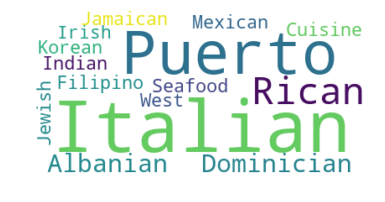

<Figure size 2160x3240 with 0 Axes>

In [329]:
# display the word cloud
plt.imshow(NYC_CUISINE_WC, interpolation='bilinear')
plt.axis('off')

fig = plt.figure()
fig.set_figwidth(30)
fig.set_figheight(45)

plt.show()

Most Preferred Food in New York City -

1.Italian                                                                                   
2.Purto Rican                                                                          
3.Mexican                                                                                   
4.Jewish                                                           
5.Indian                                                                    
6.Pakistani                                                    
7.Dominican

### 2. BROOKLYN CUISINE - WORD CLOUD

In [331]:

body = client_c7e3575de19f43f08285faec1ab7127a.get_object(Bucket='finalprojectcapstone-donotdelete-pr-c46iju8thx9lzw',Key='Brookline_Cuisine.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_4 = pd.read_csv(body)
df_data_4.head()


,Unnamed: 0,Borough,Neighborhood,Cuisine
0,22,Brooklyn,Bay Ridge,"Irish, Italian, Greek, Turkish, Lebanese, Pale..."
1,23,Brooklyn,Bedford-Stuyvesant,"African-American, Jamaican, Trinidadian, Puert..."
2,24,Brooklyn,Bensonhurst,"Italian, Chinese, Turkish, Russian, Mexican, U..."
3,25,Brooklyn,Borough Park,"Jewish, Italian, Mexican, Chinese"
4,26,Brooklyn,Brighton Beach,"Russian, Georgian, Turkish, Pakistani and Ukra..."


In [333]:
Brooklyn_CUISINE =df_data_4.drop(columns="Unnamed: 0")
Brooklyn_CUISINE.head()

,Borough,Neighborhood,Cuisine
0,Brooklyn,Bay Ridge,"Irish, Italian, Greek, Turkish, Lebanese, Pale..."
1,Brooklyn,Bedford-Stuyvesant,"African-American, Jamaican, Trinidadian, Puert..."
2,Brooklyn,Bensonhurst,"Italian, Chinese, Turkish, Russian, Mexican, U..."
3,Brooklyn,Borough Park,"Jewish, Italian, Mexican, Chinese"
4,Brooklyn,Brighton Beach,"Russian, Georgian, Turkish, Pakistani and Ukra..."


In [334]:
BR_CUISINE_WC = Brooklyn_CUISINE[['Cuisine']]
BR_CUISINE_WC

,Cuisine
0,"Irish, Italian, Greek, Turkish, Lebanese, Pale..."
1,"African-American, Jamaican, Trinidadian, Puert..."
2,"Italian, Chinese, Turkish, Russian, Mexican, U..."
3,"Jewish, Italian, Mexican, Chinese"
4,"Russian, Georgian, Turkish, Pakistani and Ukra..."
5,"Puerto Rican, Mexican, Dominican, and Ecuadorian"
6,"Jamaican, West Indian, African-American"
7,Italian
8,"Jamaican, West Indian, and Jewish"
9,"African-American, Dominican, and Puerto Rican"


In [335]:
BR_CUISINE_WC.to_csv('BR_CUISINE.txt', sep=',', index=False)

In [336]:
BR_CUISINE_WC = open('BR_CUISINE.txt', 'r').read()

In [337]:
stopwords = set(STOPWORDS)

In [338]:
# instantiate a word cloud object
BR_CUISINE_NYC = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
BR_CUISINE_NYC.generate(BR_CUISINE_WC)

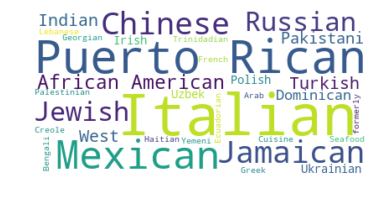

<Figure size 2160x3240 with 0 Axes>

In [339]:
# display the word cloud
plt.imshow(BR_CUISINE_NYC, interpolation='bilinear')
plt.axis('off')

fig = plt.figure()
fig.set_figwidth(30)
fig.set_figheight(45)

plt.show()

Most Preferred Food in Brooklyn is -

1.Italian                                                                     
2.Purto Rican                                                            
3.Mexican

### 3. QUEENS CUISINE - WORD CLOUD

In [340]:

body = client_c7e3575de19f43f08285faec1ab7127a.get_object(Bucket='finalprojectcapstone-donotdelete-pr-c46iju8thx9lzw',Key='Queens_Cuisine.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_5 = pd.read_csv(body)
df_data_5.head()


,Unnamed: 0,Borough,Neighborhood,Cuisine
0,9,Queens,Astoria,"Greek, Italian, Eastern European, Brazilian"
1,10,Queens,Bellerose,Indian and Pakistani
2,11,Queens,Flushing,Chinese and Korean
3,12,Queens,Forest Hills,Jewish and Russian
4,13,Queens,Howard Beach,Italian


In [342]:
Q_CUISINE_WC = df_data_5[['Cuisine']]
Q_CUISINE_WC

,Cuisine
0,"Greek, Italian, Eastern European, Brazilian"
1,Indian and Pakistani
2,Chinese and Korean
3,Jewish and Russian
4,Italian
5,German and Polish
6,"Indian, Pakistani, Bangladeshi, Peruvian, Fili..."
7,"Bangladeshi, Carribbean, African-American"
8,"Arab, Chinese and Italian"
9,"Indian, Guyanese, Pakistani, Bangladeshi"


In [343]:
Q_CUISINE_WC.to_csv('Q_CUISINE.txt', sep=',', index=False)

In [344]:
Q_CUISINE_WC = open('Q_CUISINE.txt', 'r').read()

In [345]:
stopwords = set(STOPWORDS)

In [346]:
# instantiate a word cloud object
Q_CUISINE_NYC = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
Q_CUISINE_NYC.generate(Q_CUISINE_WC)

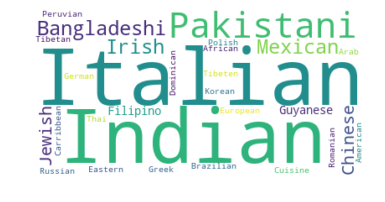

<Figure size 2160x3240 with 0 Axes>

In [347]:
plt.imshow(Q_CUISINE_NYC, interpolation='bilinear')
plt.axis('off')

fig = plt.figure()
fig.set_figwidth(30)
fig.set_figheight(45)

plt.show()

Most Preferred Food in Queens is -

1.Indian                                               
2.Irish                                              
3.Pakistani                                      
4.Mexican

### 4. SATEN ISLAND CUISINE - WORD CLOUD

In [351]:

body = client_c7e3575de19f43f08285faec1ab7127a.get_object(Bucket='finalprojectcapstone-donotdelete-pr-c46iju8thx9lzw',Key='Saten_Island_Cuisine.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_6 = pd.read_csv(body)
df_data_6.head()


,Unnamed: 0,Borough,Neighborhood,Cuisine
0,41,Staten Island,Port Richmond,"Mexican, Indian, Italian"
1,42,Staten Island,Rossville,"Italian, Russian, Arab and Polish"
2,43,Staten Island,Tompkinsville,"Italian, Sri Lankan, Pakistani, Indian"


In [352]:
SI_CUISINE_WC = df_data_6[['Cuisine']]
SI_CUISINE_WC

,Cuisine
0,"Mexican, Indian, Italian"
1,"Italian, Russian, Arab and Polish"
2,"Italian, Sri Lankan, Pakistani, Indian"


In [353]:
SI_CUISINE_WC.to_csv('SI_CUISINE.txt', sep=',', index=False)

In [354]:
SI_CUISINE_WC = open('SI_CUISINE.txt', 'r').read()

In [355]:
stopwords = set(STOPWORDS)

In [356]:
# instantiate a word cloud object
SI_CUISINE_NYC = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
SI_CUISINE_NYC.generate(SI_CUISINE_WC)

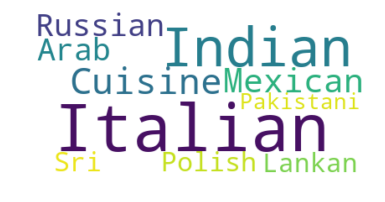

<Figure size 2160x3240 with 0 Axes>

In [357]:
plt.imshow(SI_CUISINE_NYC, interpolation='bilinear')
plt.axis('off')

fig = plt.figure()
fig.set_figwidth(30)
fig.set_figheight(45)

plt.show()

Most Preferred Food in Saten Island is -

1.Italian                                                                                          
2.Indian                                                                                                        
3.Mexican